In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.001
num_episodes = 10000
gamma=0.9999
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=500000

batch_size=32

update_target_frequency = 1500

clip_error=False

double_dqn=True

In [9]:
env = gym.make('CartPole-v0')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
o=torch.arange(20,dtype=torch.float32).view(-1,4).contiguous()

In [14]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [15]:
class NeuralNetworkDueling(nn.Module):
    def __init__(self):
        super(NeuralNetworkDueling, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.advantage = nn.Linear(hidden_layer_size,number_of_outputs)
        self.value = nn.Linear(hidden_layer_size,1)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        
        #print('x shape {} and value:'.format(x.shape))
        #print(x.detach().cpu())
        
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        
        #print('output1 shape {} and value:'.format(output1.shape))
        #print(output1.detach().cpu())
        
        output_advantage=self.advantage(output1)
        output_value=self.value(output1)
        
        #print('output_advantage shape {} and value:'.format(output_advantage.shape))
        #print(output_advantage.detach().cpu())
        
        #print('output_value shape {} and value:'.format(output_value.shape))
        #print(output_value.detach().cpu())
        
        #print('output_advantage.mean shape {} and value:'.format(output_advantage.mean(dim=1,keepdim=True).shape))
        #print(output_advantage.mean(dim=1,keepdim=True).detach().cpu())
        
        output_final=output_value+output_advantage-output_advantage.mean(dim=1,keepdim=True)
        
        
        return output_final

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [17]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetworkDueling().to(device)
        self.target_nn = NeuralNetworkDueling().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state.unsqueeze(dim=0)).squeeze()
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
            
        if double_dqn:
            #print('in double DQN')
            new_state_values_from_nn=self.nn(new_state).detach()
            #print('new_state_values_from_nn shape {} and value:'.format(new_state_values_from_nn.shape))
            #print(new_state_values_from_nn)
            max_new_state_indexes=torch.max(new_state_values_from_nn,dim=1)[1].view(-1,1)
            #print('max_new_state_indexes shape {} and value:'.format(max_new_state_indexes.shape))
            #print(max_new_state_indexes)
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value:'.format(new_state_values.shape))
            #print(new_state_values)
            max_new_state_values=torch.gather(new_state_values,1,max_new_state_indexes).squeeze()
            #print('max_new_state_values shape {} and value:'.format(max_new_state_values.shape))
            #print(max_new_state_values)
        else:
            #print('in regular DQN')
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value'.format(new_state_values.shape))
            #print(new_state_values)
        
            max_new_state_values=torch.max(new_state_values,dim=1)[0]
            #print('max_new_state_values shape {} and value'.format(max_new_state_values.shape))
            #print(max_new_state_values)
            
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [18]:
memory=ExperienceReplay(replay_memory_size)

In [19]:
qnet_agent=QNet_Agent()

In [20]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [21]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 18.3
Average over all episodes so far: 18.3
epsilon: 0.6077792046191888
**** Episode  20 **** 
Recent average reward: 16.6
Average over all episodes so far: 17.45
epsilon: 0.4329362518006686
**** Episode  30 **** 
Recent average reward: 12.5
Average over all episodes so far: 15.8
epsilon: 0.3460370637724424
**** Episode  40 **** 
Recent average reward: 10.5
Average over all episodes so far: 14.475
epsilon: 0.28347807735500685
**** Episode  50 **** 
Recent average reward: 12.7
Average over all episodes so far: 14.12
epsilon: 0.2217108572251238
**** Episode  60 **** 
Recent average reward: 10.7
Average over all episodes so far: 13.55
epsilon: 0.18126660958666668
**** Episode  70 **** 
Recent average reward: 10.3
Average over all episodes so far: 13.085714285714285
epsilon: 0.1499410780191286
**** Episode  80 **** 
Recent average reward: 9.9
Average over all episodes so far: 12.6875
epsilon: 0.12480344162250226
**** Episode  90 **** 
Recent av

**** Episode  550 **** 
Recent average reward: 12.5
Reward over last 100: 12.41
Average over all episodes so far: 11.732727272727272
epsilon: 0.010002166204898409
**** Episode  560 **** 
Recent average reward: 15.1
Reward over last 100: 12.86
Average over all episodes so far: 11.792857142857143
epsilon: 0.01000152344884518
**** Episode  570 **** 
Recent average reward: 15.0
Reward over last 100: 13.22
Average over all episodes so far: 11.849122807017544
epsilon: 0.010001188838454411
**** Episode  580 **** 
Recent average reward: 10.8
Reward over last 100: 13.08
Average over all episodes so far: 11.831034482758621
epsilon: 0.010000918490921624
**** Episode  590 **** 
Recent average reward: 12.6
Reward over last 100: 13.05
Average over all episodes so far: 11.844067796610169
epsilon: 0.01000071818846501
**** Episode  600 **** 
Recent average reward: 19.4
Reward over last 100: 13.81
Average over all episodes so far: 11.97
epsilon: 0.01000049607742865
**** Episode  610 **** 
Recent average

**** Episode  1090 **** 
Recent average reward: 175.0
Reward over last 100: 170.67
Average over all episodes so far: 76.54311926605504
epsilon: 0.01
**** Episode  1100 **** 
Recent average reward: 169.9
Reward over last 100: 170.92
Average over all episodes so far: 77.39181818181818
epsilon: 0.01
**** Episode  1110 **** 
Recent average reward: 167.4
Reward over last 100: 171.21
Average over all episodes so far: 78.20270270270271
epsilon: 0.01
**** Episode  1120 **** 
Recent average reward: 166.0
Reward over last 100: 171.18
Average over all episodes so far: 78.98660714285714
epsilon: 0.01
**** Episode  1130 **** 
Recent average reward: 168.8
Reward over last 100: 171.56
Average over all episodes so far: 79.78141592920353
epsilon: 0.01
**** Episode  1140 **** 
Recent average reward: 175.2
Reward over last 100: 171.89
Average over all episodes so far: 80.61842105263158
epsilon: 0.01
**** Episode  1150 **** 
Recent average reward: 175.3
Reward over last 100: 172.5
Average over all episode

**** Episode  1650 **** 
Recent average reward: 181.2
Reward over last 100: 174.72
Average over all episodes so far: 109.27575757575758
epsilon: 0.01
**** Episode  1660 **** 
Recent average reward: 173.6
Reward over last 100: 174.62
Average over all episodes so far: 109.66325301204819
epsilon: 0.01
**** Episode  1670 **** 
Recent average reward: 176.1
Reward over last 100: 175.67
Average over all episodes so far: 110.06107784431137
epsilon: 0.01
**** Episode  1680 **** 
Recent average reward: 171.2
Reward over last 100: 175.39
Average over all episodes so far: 110.425
epsilon: 0.01
**** Episode  1690 **** 
Recent average reward: 180.4
Reward over last 100: 175.57
Average over all episodes so far: 110.83905325443787
epsilon: 0.01
**** Episode  1700 **** 
Recent average reward: 186.7
Reward over last 100: 176.05
Average over all episodes so far: 111.28529411764706
epsilon: 0.01
**** Episode  1710 **** 
Recent average reward: 187.0
Reward over last 100: 177.93
Average over all episodes so

**** Episode  2200 **** 
Recent average reward: 183.2
Reward over last 100: 178.28
Average over all episodes so far: 126.63
epsilon: 0.01
**** Episode  2210 **** 
Recent average reward: 182.7
Reward over last 100: 177.79
Average over all episodes so far: 126.88371040723982
epsilon: 0.01
**** Episode  2220 **** 
Recent average reward: 169.0
Reward over last 100: 177.24
Average over all episodes so far: 127.07342342342342
epsilon: 0.01
**** Episode  2230 **** 
Recent average reward: 181.4
Reward over last 100: 178.15
Average over all episodes so far: 127.31704035874439
epsilon: 0.01
**** Episode  2240 **** 
Recent average reward: 166.4
Reward over last 100: 176.92
Average over all episodes so far: 127.49151785714285
epsilon: 0.01
**** Episode  2250 **** 
Recent average reward: 171.4
Reward over last 100: 175.94
Average over all episodes so far: 127.68666666666667
epsilon: 0.01
**** Episode  2260 **** 
Recent average reward: 166.7
Reward over last 100: 174.99
Average over all episodes so 

**** Episode  2760 **** 
Recent average reward: 197.9
Reward over last 100: 193.01
Average over all episodes so far: 138.63152173913045
epsilon: 0.01
**** Episode  2770 **** 
Recent average reward: 190.6
Reward over last 100: 192.4
Average over all episodes so far: 138.81913357400722
epsilon: 0.01
**** Episode  2780 **** 
Recent average reward: 191.2
Reward over last 100: 192.16
Average over all episodes so far: 139.00755395683453
epsilon: 0.01
**** Episode  2790 **** 
Recent average reward: 184.5
Reward over last 100: 191.29
Average over all episodes so far: 139.1706093189964
epsilon: 0.01
**** Episode  2800 **** 
Recent average reward: 180.5
Reward over last 100: 190.48
Average over all episodes so far: 139.31821428571428
epsilon: 0.01
**** Episode  2810 **** 
Recent average reward: 196.2
Reward over last 100: 190.66
Average over all episodes so far: 139.52064056939503
epsilon: 0.01
**** Episode  2820 **** 
Recent average reward: 187.4
Reward over last 100: 190.79
Average over all ep

**** Episode  3310 **** 
Recent average reward: 197.7
Reward over last 100: 197.16
Average over all episodes so far: 148.10815709969788
epsilon: 0.01
**** Episode  3320 **** 
Recent average reward: 195.1
Reward over last 100: 196.67
Average over all episodes so far: 148.24969879518073
epsilon: 0.01
**** Episode  3330 **** 
Recent average reward: 196.2
Reward over last 100: 196.35
Average over all episodes so far: 148.3936936936937
epsilon: 0.01
**** Episode  3340 **** 
Recent average reward: 195.8
Reward over last 100: 196.24
Average over all episodes so far: 148.53562874251497
epsilon: 0.01
**** Episode  3350 **** 
Recent average reward: 197.2
Reward over last 100: 196.74
Average over all episodes so far: 148.68089552238806
epsilon: 0.01
**** Episode  3360 **** 
Recent average reward: 199.3
Reward over last 100: 197.02
Average over all episodes so far: 148.83154761904763
epsilon: 0.01
**** Episode  3370 **** 
Recent average reward: 195.7
Reward over last 100: 196.59
Average over all e

**** Episode  3860 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 155.37512953367875
epsilon: 0.01
**** Episode  3870 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 155.4904392764858
epsilon: 0.01
**** Episode  3880 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 155.60515463917525
epsilon: 0.01
**** Episode  3890 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 155.71928020565554
epsilon: 0.01
**** Episode  3900 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 155.83282051282052
epsilon: 0.01
**** Episode  3910 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 155.9457800511509
epsilon: 0.01
**** Episode  3920 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes 

**** Episode  4420 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 161.0289592760181
epsilon: 0.01
**** Episode  4430 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 161.11693002257337
epsilon: 0.01
**** Episode  4440 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 161.2045045045045
epsilon: 0.01
**** Episode  4450 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 161.29168539325843
epsilon: 0.01
**** Episode  4460 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 161.37847533632288
epsilon: 0.01
**** Episode  4470 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 161.4648769574944
epsilon: 0.01
**** Episode  4480 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes s

**** Episode  4980 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 165.41124497991967
epsilon: 0.01
**** Episode  4990 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 165.4805611222445
epsilon: 0.01
**** Episode  5000 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 165.5496
epsilon: 0.01
**** Episode  5010 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 165.6183632734531
epsilon: 0.01
**** Episode  5020 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 165.68685258964143
epsilon: 0.01
**** Episode  5030 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 165.75506958250497
epsilon: 0.01
**** Episode  5040 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 16

**** Episode  5540 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 168.90758122743682
epsilon: 0.01
**** Episode  5550 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 168.96360360360362
epsilon: 0.01
**** Episode  5560 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 169.01942446043165
epsilon: 0.01
**** Episode  5570 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 169.0750448833034
epsilon: 0.01
**** Episode  5580 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 169.1304659498208
epsilon: 0.01
**** Episode  5590 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 169.18568872987478
epsilon: 0.01
**** Episode  5600 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes 

**** Episode  6100 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 171.76196721311476
epsilon: 0.01
**** Episode  6110 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 171.80818330605564
epsilon: 0.01
**** Episode  6120 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 171.85424836601308
epsilon: 0.01
**** Episode  6130 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 171.90016313213704
epsilon: 0.01
**** Episode  6140 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 171.9459283387622
epsilon: 0.01
**** Episode  6150 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 171.99154471544716
epsilon: 0.01
**** Episode  6160 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes

**** Episode  6660 **** 
Recent average reward: 90.7
Reward over last 100: 137.39
Average over all episodes so far: 173.06411411411412
epsilon: 0.01
**** Episode  6670 **** 
Recent average reward: 145.5
Reward over last 100: 135.56
Average over all episodes so far: 173.02278860569714
epsilon: 0.01
**** Episode  6680 **** 
Recent average reward: 165.7
Reward over last 100: 137.43
Average over all episodes so far: 173.0118263473054
epsilon: 0.01
**** Episode  6690 **** 
Recent average reward: 148.1
Reward over last 100: 133.99
Average over all episodes so far: 172.9745889387145
epsilon: 0.01
**** Episode  6700 **** 
Recent average reward: 200.0
Reward over last 100: 139.19
Average over all episodes so far: 173.01492537313433
epsilon: 0.01
**** Episode  6710 **** 
Recent average reward: 200.0
Reward over last 100: 140.95
Average over all episodes so far: 173.05514157973175
epsilon: 0.01
**** Episode  6720 **** 
Recent average reward: 200.0
Reward over last 100: 146.3
Average over all epis

**** Episode  7210 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 174.89472954230237
epsilon: 0.01
**** Episode  7220 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 174.92950138504156
epsilon: 0.01
**** Episode  7230 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 174.96417704011066
epsilon: 0.01
**** Episode  7240 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 174.99875690607735
epsilon: 0.01
**** Episode  7250 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 175.03324137931034
epsilon: 0.01
**** Episode  7260 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 175.0676308539945
epsilon: 0.01
**** Episode  7270 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes

**** Episode  7770 **** 
Recent average reward: 190.6
Reward over last 100: 197.86
Average over all episodes so far: 176.611583011583
epsilon: 0.01
**** Episode  7780 **** 
Recent average reward: 200.0
Reward over last 100: 197.86
Average over all episodes so far: 176.64164524421594
epsilon: 0.01
**** Episode  7790 **** 
Recent average reward: 200.0
Reward over last 100: 197.86
Average over all episodes so far: 176.6716302952503
epsilon: 0.01
**** Episode  7800 **** 
Recent average reward: 200.0
Reward over last 100: 197.86
Average over all episodes so far: 176.70153846153846
epsilon: 0.01
**** Episode  7810 **** 
Recent average reward: 200.0
Reward over last 100: 197.86
Average over all episodes so far: 176.73137003841228
epsilon: 0.01
**** Episode  7820 **** 
Recent average reward: 200.0
Reward over last 100: 197.86
Average over all episodes so far: 176.7611253196931
epsilon: 0.01
**** Episode  7830 **** 
Recent average reward: 200.0
Reward over last 100: 197.86
Average over all epis

**** Episode  8330 **** 
Recent average reward: 200.0
Reward over last 100: 199.47
Average over all episodes so far: 178.17755102040817
epsilon: 0.01
**** Episode  8340 **** 
Recent average reward: 200.0
Reward over last 100: 199.47
Average over all episodes so far: 178.2037170263789
epsilon: 0.01
**** Episode  8350 **** 
Recent average reward: 194.7
Reward over last 100: 198.94
Average over all episodes so far: 178.2234730538922
epsilon: 0.01
**** Episode  8360 **** 
Recent average reward: 200.0
Reward over last 100: 198.94
Average over all episodes so far: 178.24952153110047
epsilon: 0.01
**** Episode  8370 **** 
Recent average reward: 200.0
Reward over last 100: 198.94
Average over all episodes so far: 178.27550776583035
epsilon: 0.01
**** Episode  8380 **** 
Recent average reward: 200.0
Reward over last 100: 198.94
Average over all episodes so far: 178.30143198090693
epsilon: 0.01
**** Episode  8390 **** 
Recent average reward: 200.0
Reward over last 100: 199.47
Average over all ep

**** Episode  8880 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 179.51666666666668
epsilon: 0.01
**** Episode  8890 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 179.53970753655793
epsilon: 0.01
**** Episode  8900 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 179.5626966292135
epsilon: 0.01
**** Episode  8910 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 179.58563411896745
epsilon: 0.01
**** Episode  8920 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 179.6085201793722
epsilon: 0.01
**** Episode  8930 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 179.6313549832027
epsilon: 0.01
**** Episode  8940 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes s

**** Episode  9430 **** 
Recent average reward: 200.0
Reward over last 100: 198.22
Average over all episodes so far: 180.00222693531282
epsilon: 0.01
**** Episode  9440 **** 
Recent average reward: 200.0
Reward over last 100: 198.22
Average over all episodes so far: 180.02341101694915
epsilon: 0.01
**** Episode  9450 **** 
Recent average reward: 200.0
Reward over last 100: 198.22
Average over all episodes so far: 180.04455026455025
epsilon: 0.01
**** Episode  9460 **** 
Recent average reward: 200.0
Reward over last 100: 199.18
Average over all episodes so far: 180.06564482029597
epsilon: 0.01
**** Episode  9470 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 180.08669482576556
epsilon: 0.01
**** Episode  9480 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 180.10770042194093
epsilon: 0.01
**** Episode  9490 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all epi

**** Episode  9990 **** 
Recent average reward: 200.0
Reward over last 100: 200.0
Average over all episodes so far: 181.12322322322322
epsilon: 0.01
Solved after 2929 episodes
CPU times: user 2h 44min 37s, sys: 9min 2s, total: 2h 53min 40s
Wall time: 2h 53min 41s


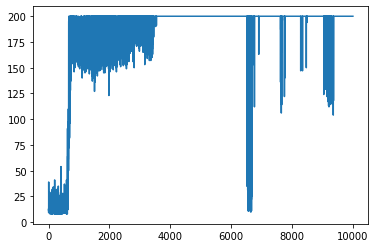

In [22]:
plt.plot(steps_total)
plt.show()

In [23]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 181.1421


In [24]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 181.1421
Average number of steps=reward in last 100 episodes: 200.0


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

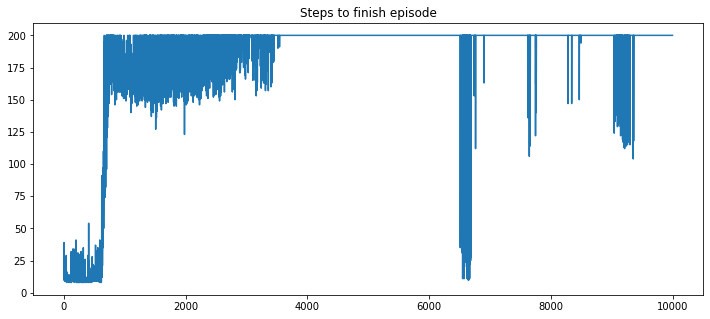

In [25]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()